### Data

In [95]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import modules
import utils

# modules.VAE
datapath = 'data/ell2.0_d10_n100000_ksigma0.100_nx101.npz'
data = np.load(datapath)
x_np = data['x']
u_sols = data['u_sols'].T
n_x = x_np.shape[0]
n_samples = u_sols.shape[0]

n_train_total = 100
n_train = int(n_train_total * 0.8)
n_val = n_train_total - n_train

u_train = torch.tensor(u_sols[:n_train], dtype=torch.float32)
u_val = torch.tensor(u_sols[n_train:n_train_total], dtype=torch.float32)
x = torch.tensor(x_np, dtype=torch.float32)

### Create Model

Failed to find a good N initialization after 1/20 iterations. Trying again.
Found good one, Starting Second Check
Success!
VAE(
  (encoder): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=99, out_features=10, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=10, out_features=10, bias=True)
      )
      (2): SineLayer(
        (linear): Linear(in_features=10, out_features=10, bias=True)
      )
      (3): Linear(in_features=10, out_features=5, bias=True)
    )
  )
  (decoder): SolutionOfPDENet(
    (N): Siren(
      (net): Sequential(
        (0): SineLayer(
          (linear): Linear(in_features=9, out_features=10, bias=True)
        )
        (1): SineLayer(
          (linear): Linear(in_features=10, out_features=10, bias=True)
        )
        (2): SineLayer(
          (linear): Linear(in_features=10, out_features=10, bias=True)
        )
        (3): Linear(in_features=10, out_features=1, bias=True)
      )
    

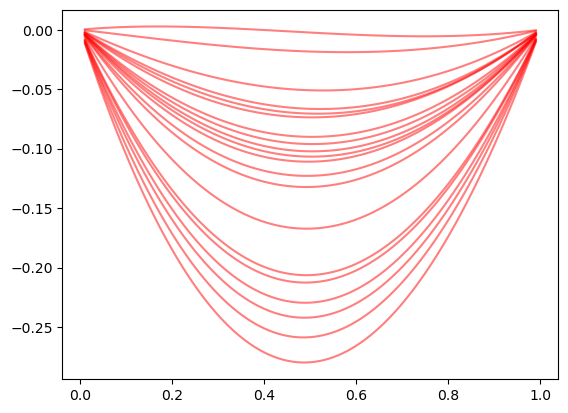

In [96]:
latent_dim = 5

omega_0 = 1.0
in_features = 4 + latent_dim
hidden_features = 10
hidden_layers = 2
out_features = 1

def get_N():
    return modules.Siren(in_features=in_features, hidden_features=hidden_features, hidden_layers=hidden_layers,
                         out_features=out_features, outermost_linear=True, first_omega_0=omega_0,
                         hidden_omega_0=omega_0)

torch.manual_seed(0)
decoder = modules.SolutionOfPDENet(get_N, x, latent_dim, init_kwaargs={'max_iter': 20, 'n_batch1': 5, 'n_batch2': 20})

encoder = modules.Siren(in_features=n_x-2, hidden_features=hidden_features, hidden_layers=hidden_layers,
                        out_features=latent_dim, outermost_linear=True, first_omega_0=omega_0,
                        hidden_omega_0=omega_0)

vae = modules.VAE(encoder, decoder, latent_dim)
print(vae)

# show baseline samples
n_samples = 20
with torch.no_grad():
    u_samples = vae.sample(n_samples)
plt.plot(x_np[1:-1], u_samples.T, 'r', alpha=0.5)

(Train) Epoch 1/500, Loss: 0.00003287, Recon Loss: 0.00000640, KL Loss: 0.83713645
 (Val)  Epoch 1/500, Loss: 0.00087318, Recon Loss: 0.00080724, KL Loss: 2.08518386
(Train) Epoch 26/500, Loss: 0.00004823, Recon Loss: 0.00002977, KL Loss: 0.58372277
 (Val)  Epoch 26/500, Loss: 0.00004052, Recon Loss: 0.00002351, KL Loss: 0.53806299
(Train) Epoch 51/500, Loss: 0.00002553, Recon Loss: 0.00001180, KL Loss: 0.43436679
 (Val)  Epoch 51/500, Loss: 0.00002825, Recon Loss: 0.00001450, KL Loss: 0.43475986
(Train) Epoch 76/500, Loss: 0.00002582, Recon Loss: 0.00001387, KL Loss: 0.37781009
 (Val)  Epoch 76/500, Loss: 0.00002376, Recon Loss: 0.00001191, KL Loss: 0.37455583
(Train) Epoch 101/500, Loss: 0.00002793, Recon Loss: 0.00001821, KL Loss: 0.30725160
 (Val)  Epoch 101/500, Loss: 0.00002644, Recon Loss: 0.00001679, KL Loss: 0.30538127
(Train) Epoch 126/500, Loss: 0.00002185, Recon Loss: 0.00001359, KL Loss: 0.26127696
 (Val)  Epoch 126/500, Loss: 0.00002156, Recon Loss: 0.00001363, KL Loss: 0

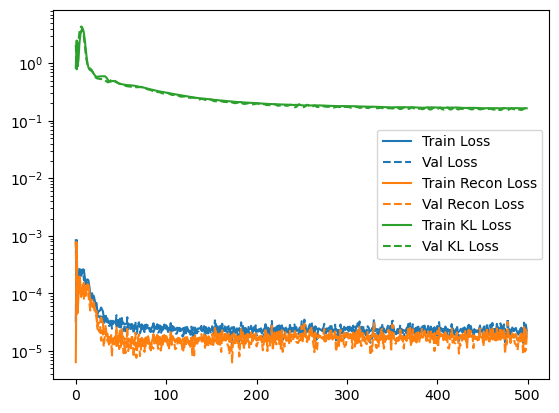

In [117]:
# batch_size = 64
batch_size = n_train
dataloader = torch.utils.data.DataLoader(u_train, batch_size=batch_size, shuffle=True)

beta = 10**-4.5
epochs = 500
lr = 3e-3
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

train_losses = np.zeros((epochs, 3))
val_losses = np.zeros((epochs, 3))

for epoch in range(epochs):
    vae.train()
    for i, batch in enumerate(dataloader):
        optimizer.zero_grad()
        loss, recon_loss, kl_loss = vae.loss_fn(batch[:,1:-1], beta=beta)
        loss.backward()
        optimizer.step()
        train_losses[epoch] += [loss.item(), recon_loss.item(), kl_loss.item()]
    if (np.isnan(train_losses[epoch,:])).any():
        print(f'NAN detected on epoch {epoch}')
        break
    vae.eval()
    with torch.no_grad():
        loss, recon_loss, kl_loss = vae.loss_fn(u_val[:,1:-1], beta=beta)
        val_losses[epoch] = [loss.item(), recon_loss.item(), kl_loss.item()]
    if epochs < 20 or epoch % (epochs//20) == 0 or epoch == epochs-1:
        print(f'(Train) Epoch {epoch+1}/{epochs}, Loss: {train_losses[epoch,0]:.8f}, '
                f'Recon Loss: {train_losses[epoch,1]:.8f}, KL Loss: {train_losses[epoch,2]:.8f}')
        print(f' (Val)  Epoch {epoch+1}/{epochs}, Loss: {val_losses[epoch,0]:.8f}, '
                f'Recon Loss: {val_losses[epoch,1]:.8f}, KL Loss: {val_losses[epoch,2]:.8f}')

plt.figure()
plt.semilogy(train_losses[:,0], label='Train Loss')
plt.semilogy(val_losses[:,0], label='Val Loss', linestyle='--', color='C0')
plt.semilogy(train_losses[:,1], label='Train Recon Loss')
plt.semilogy(val_losses[:,1], label='Val Recon Loss', linestyle='--', color='C1')
plt.semilogy(train_losses[:,2], label='Train KL Loss')
plt.semilogy(val_losses[:,2], label='Val KL Loss', linestyle='--', color='C2')
plt.legend()


In [133]:
model.x = x

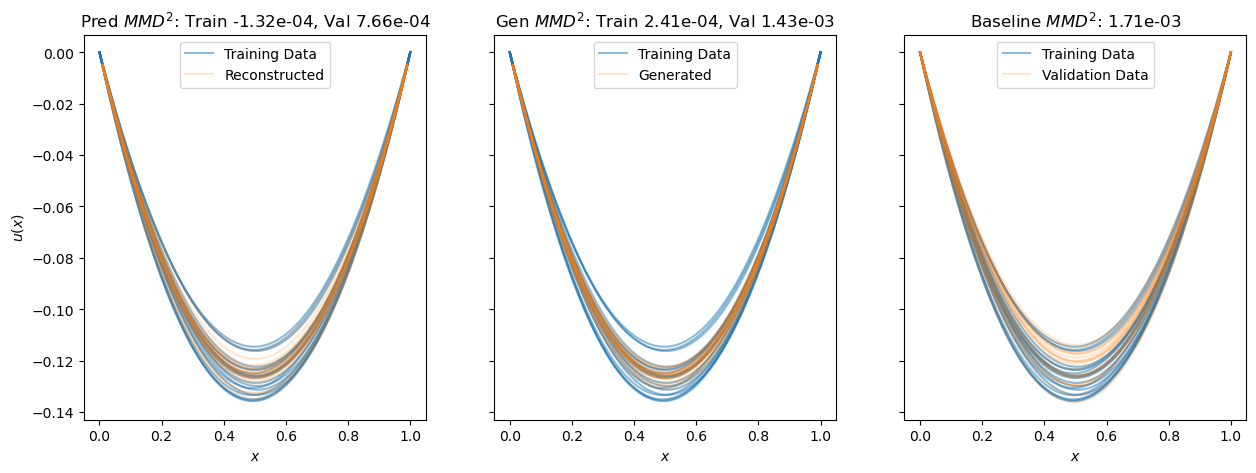

In [134]:
n_generate = min(100, n_val)
u_pred, _, _ = vae(u_train[:n_generate,1:-1])
u_generated = vae.sample(n_generate)

alphas = [0.1, 0.2, 0.5, 1.0]
mmd_pred_train = utils.mmd2_rq_mix(u_train[:1000,1:-1], u_pred, alphas)
mmd_pred_val = utils.mmd2_rq_mix(u_val[:1000,1:-1], u_pred, alphas)
mmd_gen_train = utils.mmd2_rq_mix(u_train[:1000,1:-1], u_generated, alphas)
mmd_gen_val = utils.mmd2_rq_mix(u_val[:1000,1:-1], u_generated, alphas)
mmd_baseline = utils.mmd2_rq_mix(u_val[:1000,1:-1], u_train[:n_generate,1:-1], alphas)

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
with torch.no_grad():
    ax[0].plot(x_np, u_train[:n_generate].numpy().T, color='C0', alpha=0.5)
    ax[0].plot(x_np[1:-1], u_pred[:n_generate].numpy().T, color='C1', alpha=0.2)

    ax[1].plot(x_np, u_train[:n_generate].numpy().T, color='C0', alpha=0.5)
    ax[1].plot(x_np[1:-1], u_generated.T, color='C1', alpha=0.2)

    ax[2].plot(x_np, u_train[:n_generate].numpy().T, color='C0', alpha=0.5)
    ax[2].plot(x_np, u_val[:n_generate].numpy().T, color='C1', alpha=0.2)
ax[0].set_title(f'Pred $MMD^2$: Train {mmd_pred_train:.2e}, Val {mmd_pred_val:.2e}')
ax[1].set_title(f'Gen $MMD^2$: Train {mmd_gen_train:.2e}, Val {mmd_gen_val:.2e}')
ax[2].set_title(f'Baseline $MMD^2$: {mmd_baseline:.2e}')

# custom legend for ax[0]
ax[0].plot([], [], color='C0', alpha=0.5, label='Training Data')
ax[0].plot([], [], color='C1', alpha=0.2, label='Reconstructed')
ax[0].legend()

ax[1].plot([], [], color='C0', alpha=0.5, label='Training Data')
ax[1].plot([], [], color='C1', alpha=0.2, label='Generated')
ax[1].legend()

ax[2].plot([], [], color='C0', alpha=0.5, label='Training Data')
ax[2].plot([], [], color='C1', alpha=0.2, label='Validation Data')
ax[2].legend()

ax[0].set_ylabel('$u(x)$')
for a in ax:
    a.set_xlabel('$x$')
# save
plt.savefig('vae_easy_compare.png')

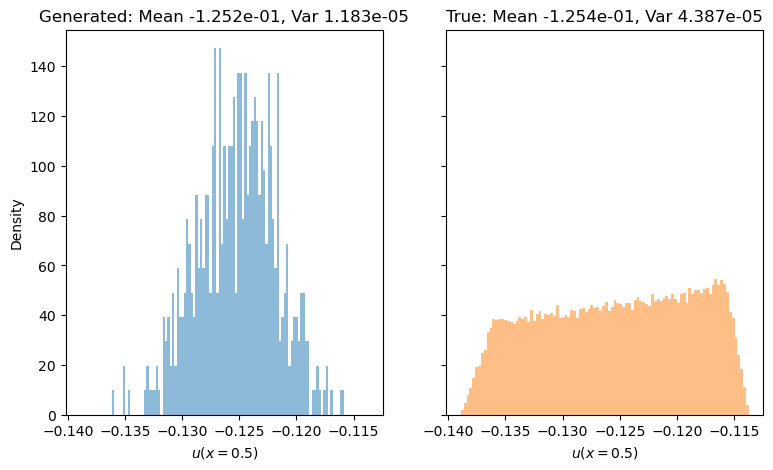

In [122]:
# generate samples and compare mean, variance, and histogram for x=0.5
n_generate = 500
examine_ind = 50
with torch.no_grad():
    u_generated = vae.sample(n_generate)
u_gen_05 = u_generated[:, examine_ind-1]
u_gen_05_np = u_gen_05.numpy()
u_gen_05_mean = u_gen_05_np.mean()
u_gen_05_var = u_gen_05_np.var()
u_sols_05 = u_sols[:,examine_ind]
u_sols_05_mean = u_sols_05.mean()
u_sols_05_var = u_sols_05.var()

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9,5))
ax[0].hist(u_gen_05_np, bins=100, alpha=0.5, density=True, color='C0')
ax[1].hist(u_sols_05, bins=100, alpha=0.5, density=True, color='C1')
ax[0].set_title(f'Generated: Mean {u_gen_05_mean:.3e}, Var {u_gen_05_var:.3e}')
ax[1].set_title(f'True: Mean {u_sols_05_mean:.3e}, Var {u_sols_05_var:.3e}')
ax[0].set_xlabel('$u(x=0.5)$')
ax[1].set_xlabel('$u(x=0.5)$')
ax[0].set_ylabel('Density')
# plt.suptitle(f'N={n_train_total} Training Samples, Batch Size = {batch_size}')
plt.savefig('vae_easy_hist.png')

torch.Size([80, 5]) torch.Size([80, 5])


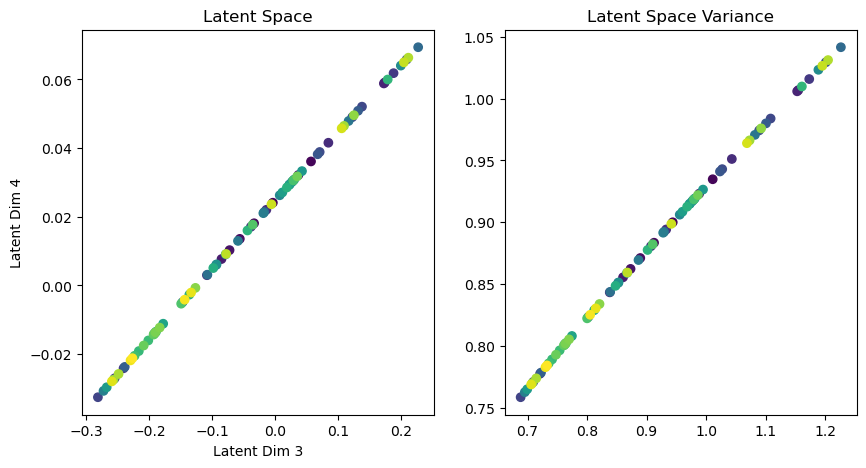

In [113]:
# show the latent space, for all the training samples
with torch.no_grad():
    mean, logvar = vae.encode(u_train[:,1:-1])
    print(mean.shape, logvar.shape)
    var = logvar.exp()

    # look at dims 1 and 2
    dim1 = 3
    dim2 = 4
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].scatter(mean[:,dim1], mean[:,dim2], c=np.arange(n_train), cmap='viridis')
    ax[0].set_title('Latent Space')
    ax[0].set_xlabel(f'Latent Dim {dim1}')
    ax[0].set_ylabel(f'Latent Dim {dim2}')
    ax[1].scatter(var[:,dim1], var[:,dim2], c=np.arange(n_train), cmap='viridis')
    ax[1].set_title('Latent Space Variance')
    # plot beta
    # ax[1].plot([0, 1], [1/beta, 1/beta], 'r--')


### Inference

In [125]:
right_bc = -0.0
left_bc = -0.0
new_x = torch.linspace(0, 1, (len(x)-1)*10 + 1)

class TrueDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.stab_term = 0.0
        self.newton_kwaargs = {}
        self.x = x

    def N(self, big_u_z):
        uxx = big_u_z[:,3:4]
        return uxx - 1


def _general_f(model, u_int, z):
    u = torch.zeros_like(model.x)
    u[0] = left_bc
    u[-1] = right_bc
    u[1:-1] = u_int
    ux = utils.fd_centered(u, model.x)
    uxx = utils.fd_centered_2nd(u, model.x)
    big_u = torch.stack([model.x[1:-1], u[1:-1], ux, uxx], dim=1)
    big_u_z = torch.cat([big_u, z.repeat(big_u.shape[0], 1)], dim=1)
    N_res = model.N(big_u_z)[:,0]
    stab_N_res = N_res + model.stab_term * uxx
    return stab_N_res

def _single_forward(model, u_int, z):
    """
    Newton solve of `_general_f` for a single `u_int` and `z`.
    """
    f = lambda u_int: _general_f(model, u_int, z)
    u_int = utils.newton_solve(f, u_int, **model.newton_kwaargs)
    return u_int

true_decoder = TrueDecoder()

model = vae.decoder
model.x = new_x

z_batch = torch.randn((n_generate, latent_dim))
u_int_batch = torch.zeros((z_batch.shape[0], len(vae.decoder.x)-2), device=z_batch.device, dtype=z_batch.dtype)

# u_int_batch[:,-1] = right_bc
for i in range(z_batch.shape[0]):
    u_int = u_int_batch[i]
    z = z_batch[i]
    with torch.no_grad():
        u_int = _single_forward(model, u_int, z)
    u_int_batch[i] = u_int

In [129]:
vae.decoder.x[1:-1].shape
u_sols.T[:,:n_generate].shape

(101, 500)

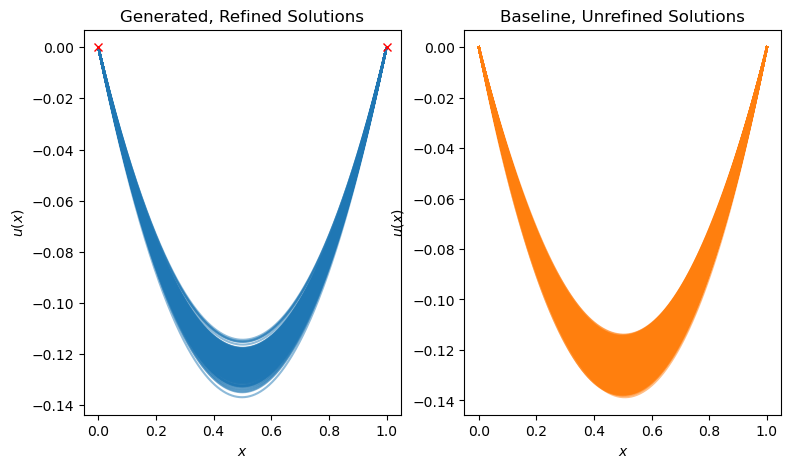

In [132]:
# plot it
fig, ax = plt.subplots(1, 2, figsize=(9,5))
ax[0].plot(vae.decoder.x[1:-1], u_int_batch.T, 'C0', alpha=0.5)
ax[0].set_title('Generated, Refined Solutions')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$u(x)$')
# ax[0].set_ylim(-0.2, 0)
# plot new bc with an x for x=0 and x=1
ax[0].plot([0, 1], [left_bc, right_bc], 'rx')

# show baseline
ax[1].plot(x_np, u_sols.T[:, :n_generate], 'C1', alpha=0.5)
ax[1].set_title('Baseline, Unrefined Solutions')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$u(x)$')

plt.savefig('vae_refined.png')


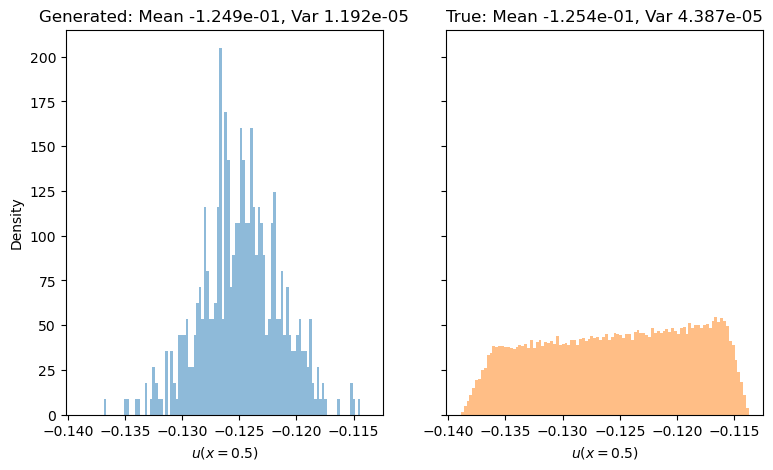

In [137]:
examine_ind_coarse = 50
examine_ind_fine = 500
u_gen_05 = u_int_batch[:, examine_ind_fine-1]
u_gen_05_np = u_gen_05.numpy()
u_gen_05_mean = u_gen_05_np.mean()
u_gen_05_var = u_gen_05_np.var()
u_sols_05 = u_sols[:, examine_ind]
u_sols_05_mean = u_sols_05.mean()
u_sols_05_var = u_sols_05.var()

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 5))
ax[0].hist(u_gen_05_np, bins=100, alpha=0.5, density=True, color='C0')
ax[1].hist(u_sols_05, bins=100, alpha=0.5, density=True, color='C1')
ax[0].set_title(f'Generated: Mean {u_gen_05_mean:.3e}, Var {u_gen_05_var:.3e}')
ax[1].set_title(f'True: Mean {u_sols_05_mean:.3e}, Var {u_sols_05_var:.3e}')
ax[0].set_xlabel('$u(x=0.5)$')
ax[1].set_xlabel('$u(x=0.5)$')
ax[0].set_ylabel('Density')
# plt.suptitle(f'N={n_train_total} Training Samples, Batch Size = {batch_size}')
plt.savefig('vae_hist_refine.png')